In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
# Timer to measure the performance of methods
from time import time
# Import scipy to get sparse arrays
from scipy import sparse
from scipy.sparse import linalg
from tqdm.notebook import trange

# Partial Differential Equations (PDEs)

The numerical solution of PDEs is a vast topic, about which numerous books have been written. There are a large variety of different methods, that are suited to different problems. We can only treat a tiny selection of these here, but there exist several different courses at NTNU that deal with numerical solution of PDEs in more detail, and I encourage you to look into those if you would like to learn more. Some examples:
* TMA4212 - Numerical solution of differential equations by difference methods
* TMA4220 - Numerical Solution of Partial Differential Equations Using Element Methods
* TMR4340 - Marine CFD
* TEP4165 - Computational Heat and Fluid Flow
* TEP4280 - Introduction to Computational Fluid Dynamics
* EP8408 - High Order Methods in Fluid Dynamics
* EP8410 - Numerical Methods for Hyperbolic Problems in Fluid Dynamics

In this course, we can only cover a tiny selection of problems, and we will only use finite difference methods.

## Poisson or Laplace equation


The Laplace equation

$$ \nabla^2 \phi = 0 $$

and the Poisson equation

$$ \nabla^2 \phi = f $$

are examples of second-order linear (or quasi-linear, depending on $f$) partial differential equations, and belong to the class known as *elliptic PDEs*. These equations do not describe a time development, but rather they describe the steady-state of some function $\phi$ on some domain.

To solve them, we need boundary conditions, and for the Poisson equation we need to know $f$.

### Example: The Poisson equation in 2D

In two dimensions, the Poisson equation becomes

$$ \frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = f(x, y). $$

We wish to solve the equation on the domain $x \in [0, 2]$, $y \in [0, 1]$. We discretise space, such that

$$ x_n = n \Delta x, \;\; y_n = n \Delta y.$$

We also define the shorthand notation

$$ \phi_{i,j} = \phi(x_i, y_j), \;\;\; f_{i,j} = f(x_i, y_j).$$

The boundary conditions are

$$ \phi(x = 0, y) = 0, \;\; \phi(x = 2, y) = 0, \;\; \phi(x, y=0) = 0, \;\; \phi(x, y=1) = 0, $$

and the function $f$ is given by two delta functions in the points (0.75, 0.75) and (1.25, 0.25):

$$ f(x, y) = \delta(x - 0.75, y - 0.75) + \delta(x - 1.25, y - 0.25). $$

#### Discretise the partial derivatives

We approximate the partial derivatives using finite differences:

$$ \left. \frac{\partial^2 \phi(x, y)}{\partial x^2} \right|_{x_i, y_j} \approx \frac{\phi(x_{i+1}, y_j) - 2\phi(x_i,y_j) + \phi(x_{i-1}, y_j)}{\Delta x^2},$$

$$ \left. \frac{\partial^2 \phi(x, y)}{\partial y^2} \right|_{x_i, y_j} \approx \frac{\phi(x_i, y_{j+1}) - 2\phi(x_i,y_j) + \phi(x_i, y_{j-1})}{\Delta y^2}.$$

Inserting this into the Poisson equation, we obtain the following discrete version:

$$ \frac{\phi(x_{i+1}, y_j) - 2\phi(x_i,y_j) + \phi(x_{i-1}, y_j)}{\Delta x^2} + \frac{\phi(x_i, y_{j+1}) - 2\phi(x_i,y_j) + \phi(x_i, y_{j-1})}{\Delta y^2} = f(x_i, y_j), $$

where the discrete delta function is given by

$$ \delta(x_i - x_k, y_j - y_l) = \left\{ \begin{array}{ccc} \frac{1}{\Delta x \Delta y} & \mathrm{if} & i=k \;\mathrm{and}\; j=l \\ 0 & \mathrm{otherwise} \end{array}\right. . $$

Choosing for simplicity $ \Delta x = \Delta y$, we can rewrite this into an equation for $\phi_{i,j}$:

$$ \phi_{i,j} = \frac{\Delta x}{4} \left[ \phi_{i+1, j} + \phi_{i-1, j} + \phi_{i, j+1} + \phi_{i, j-1} + f_{i,j} \right]. $$

Here we have two options:
* Treating $\mathbf{\phi}$ as a "flattened" vector containing all the points in the 2D grid, and rewrite into matrix form: $\mathbf{A} \mathbf{\phi} = \mathbf{f}$. Here, $\mathbf{A}$ will be a sparse matrix (since each point is only "connected" to four other points, each row in $\mathbf{A}$ will only have five non-zero entries), and the system can be solved with direct or iterative methods (see notebook 10).
* Apply the above directly as an iterative method, starting from an initial guess for all $\phi_{i,j}$ (with some optional variations, see below).

In [2]:
# Boundaries of the domain
Xmin = 0
Xmax = 2
Ymin = 0
Ymax = 1
# Choose number of points (this then specifies the grid spacing, could also go the opposite way)
Nx = 201
Ny = 101
X, dx = np.linspace(Xmin, Xmax, Nx, retstep = True)
Y, dy = np.linspace(Ymin, Ymax, Ny, retstep = True)
# Confirm that dx = dy as we wanted
assert np.abs(dx - dy) < 1e-14


# Discrete version of function f
f = np.zeros((Nx, Ny))
# Find indices that are closest to specified positions
i1 = np.argmin(np.abs(X - 0.75))
j1 = np.argmin(np.abs(Y - 0.75))
i2 = np.argmin(np.abs(X - 1.25))
j2 = np.argmin(np.abs(Y - 0.25))
f[i1,j1] = 1/(dx*dy)
f[i2,j2] = 1/(dx*dy)


# Array to hold solution
phi_now  = np.zeros((Nx, Ny))

# Boundaries
phi_now[ 0, :] = 0.0
phi_now[-1, :] = 0.0
phi_now[ :, 0] = 0.0
phi_now[ :,-1] = 0.0

# Initial guess in the interior:
phi_now[1:Nx-1, 1:Ny-1] = 0.0
# An extra array for iterations
phi_next = phi_now.copy()

# Tolerance, to determine when solution is close enough
tol = 1e-3
# variable to measure error:
err = 2*tol

# Now we are ready to proceed with the update loop
tic = time()
while err > tol:
    # Calculate next step, updating interior cells only
    # then copy: next -> current
    phi_next[1:Nx-1, 1:Ny-1] = (
        phi_now[2:,1:Ny-1] + phi_now[:Nx-2,1:Ny-1] 
        +   phi_now[1:Nx-1,2:] + phi_now[1:Nx-1,:Ny-2]
        )/4 + f[1:Nx-1, 1:Ny-1]
    
    # Calculate error:
    err = np.linalg.norm(phi_next - phi_now)
    print('Error: %.3e' % err, '\r', end = '')
    
    # Copy (after calculating error)
    phi_now = phi_next.copy()

toc = time()
print('The calculation took %s seconds' % (toc - tic))

The calculation took 23.830790042877197 seconds


<ipython-input-3-8f91aec1acd3>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = plt.pcolormesh(X, Y, phi_now.T)


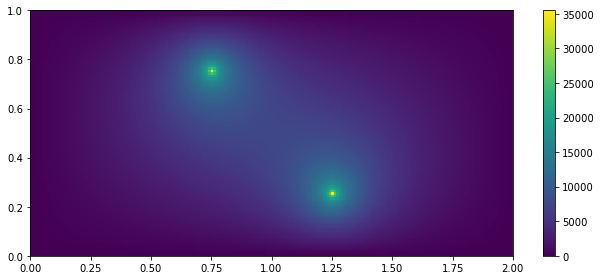

In [3]:
# Plotting as heatmap
fig = plt.figure(figsize = (9,4))
mesh = plt.pcolormesh(X, Y, phi_now.T)
plt.colorbar(mesh)
plt.tight_layout()

<IPython.core.display.Javascript object>


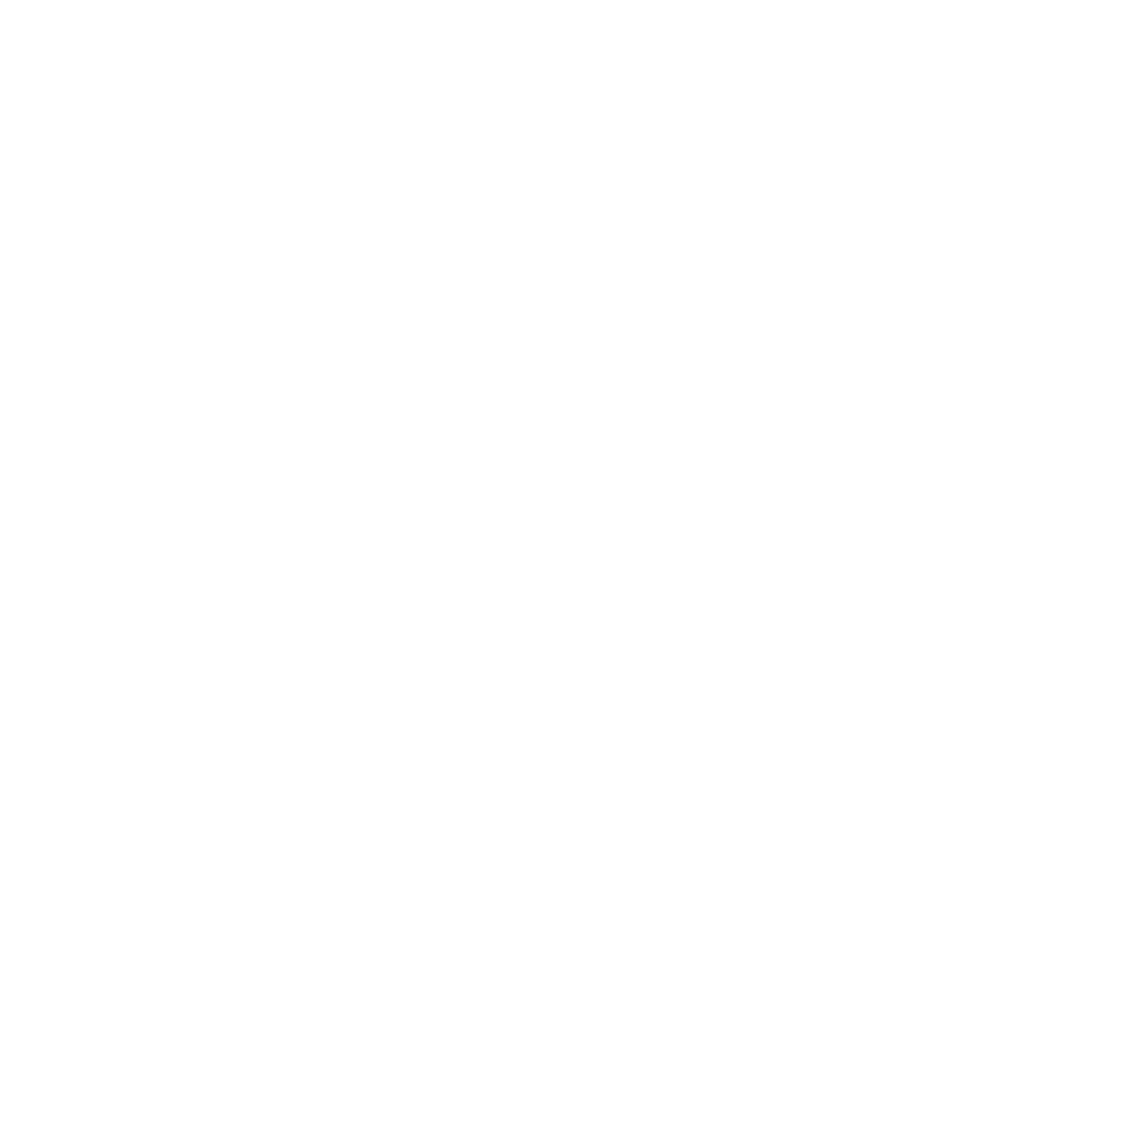

In [4]:
# Plotting as 3D surface plot
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (6,6))
Xgrid, Ygrid = np.meshgrid(Y, X) 
ax  = fig.add_subplot(111, projection = '3d')
ax.plot_surface(Xgrid, Ygrid, phi_now)

## Diffusion equation

The diffusion equation (also known as the heat equation) is given by

$$ \frac{\partial C}{\partial t} = \nabla \left( K \nabla C \right). $$

This equation is a linear second-order PDE which belongs to the class called *parabolic PDEs*. It is used in many different contexts, and it can describe how heat is conducted in a solid material, or how a chemical species diffuses in a liquid, and a range of othe things. You will use this equation in Exercise 3 in this course (spring 2021).


### Example: Explicit scheme for the diffusion equation in 1D (FTCS scheme)

In 1+1 dimensions (time + one spatial dimension), and for constant diffusivity, this becomes:

$$ \frac{\partial C}{\partial t} = K \frac{\partial^2 C}{\partial x^2}. $$

We introduce discrete variables, and shorthand notation:

$$ t_i = t_0 + i \Delta t, \;\;\; x_n = x_0 + n \Delta x, \;\;\;, C_n^i = C(t_i, x_n), \;\;\; \mathrm{where} \;\; i = 0,1,\ldots, \;\;\; n = 0, 1, \ldots, N $$

As above, we approximate the spatial derivative with a central finite difference, and we obtain the semi-discretised equation:

$$ \frac{\partial C_n(t)}{\partial t} \approx K \frac{\Delta t}{\Delta x^2} \big[ C_{n+1}(t) - 2C_n(t) + C_{n-1}(t) \big]. $$

This is now a coupled set of ordinary differential equations (ODEs), one for each "cell", and this can in principle be solved with standard ODE methods. First, we will use the forward Euler method, and later look at implicit methods (which are often more useful). Using forward Euler to discretize time, we get the fully discrete equation:

$$ C_n^{i+1} = C_n^i + K \frac{\Delta t}{\Delta x^2} \big[ C_{n+1}^i - 2C_n^i + C_{n-1}^i  \big]. $$

This scheme is called the FTCS scheme (Forward Time Central Space), because of the forward finite difference in time and the central finite difference in space.

However, we have a problem in that we have two more unknowns than equations, since the value in the boundary points, $C_0(t)$ and $C_N(t)$ depend on the value in points outside the domain. How to deal with this depends on the boundary conditions. Here, we will look at no-flux boundary conditions, i.e., we do not want our diffusing material to leave through the boundaries.

Fick's law states that the flux at any point in a diffusive system is

$$ j_D = -K \frac{\partial C}{\partial z}. $$

If we demand that the flux be zero at the boundary points, $x_0$ and $x_N$, and use the finite difference approximation of the spatial derivative, we get:

$$ j_D(x_0) \approx - K \frac{C_{1} - C_{-1}}{2 \Delta x} = 0 \Rightarrow C_{-1} = C_1, $$

$$ j_D(x_N) \approx - K \frac{C_{N+1} - C_{N-1}}{2 \Delta x} = 0 \Rightarrow C_{N+1} = C_{N-1}. $$

In this way, we can eliminate the two point outside the boundary. Note that this requires that $K>0$, but that is anyway a condition for this equation to have meaningful solutions.

Introducing the variable $\alpha = K\frac{\Delta t}{\Delta x^2}$, we can write this as a matrix-vector multiplication:

$$ \left[ \begin{array}{c} C_0^{i+1} \\ C_1^{i+1} \\ \vdots \\C_{n-1}^{i+1} \\ C_n^{i+1} \\C_{n+1}^{i+1} \\ \vdots \\ C_{N-1}^{i+1} \\C_N^{i+1} \end{array}\right] 
= \left[ \begin{array}{ccccccccc}
1 - 2\alpha & 2\alpha &0&&\cdots&&0&0&0 \\
\alpha & 1-2\alpha & \alpha&0&&&&0&0 \\
 &&&&&&&& 0 \\
 &0& \alpha & 1-2\alpha & \alpha &0&&& \\
\vdots &&0& \alpha & 1-2\alpha & \alpha &0&&\vdots \\
 &&&0& \alpha & 1-2\alpha & \alpha &0& \\
0&&&&&&&& \\
0&0&&& &0& \alpha & 1-2\alpha & \alpha\\
0&0&0&&\cdots& &0& 2\alpha & 1-2\alpha \\
\end{array}\right]
\left[ \begin{array}{c} C_0^{i} \\ C_1^{i} \\ \vdots \\C_{n-1}^{i} \\ C_n^{i} \\C_{n+1}^{i} \\ \vdots \\ C_{N-1}^{i} \\C_N^{i} \end{array}\right] $$

In [3]:
from scipy.sparse import diags
from scipy.integrate import simps
%matplotlib inline

In [6]:
# Diffusion parameter
K = 15

# Specify domain
Xmin = 0
Xmax = 100
Nx = 201
X, dx = np.linspace(Xmin, Xmax, Nx, retstep = True)

# Specify time and timestep
Tmax = 100
dt = 0.01
Nt = int(Tmax/dt)

# Check stability condition for this method
print(f'K*dt/dx**2 = {K*dt/dx**2}')

# Set up matrix for the right-hand side,
# using sparse diagonal matrix structure
alpha = K*dt/dx**2
sub_diag = alpha * np.ones(Nx-1)
main_diag = 1 - 2*alpha * np.ones(Nx)
super_diag = alpha * np.ones(Nx-1)
# Change two elements to account for boundary conditions
super_diag[0] = 2*alpha
sub_diag[-1] = 2*alpha
R = diags((sub_diag, main_diag, super_diag), offsets = (-1, 0, 1))

# Initial value, a couple of Gaussians:
mu1, sigma1 = 46, 4
mu2, sigma2 = 53, 2
C0 = 0.5 *( (1/(sigma1*np.sqrt(2*np.pi))) * np.exp(-((X - mu1)/sigma1)**2 / 2) \
           + (1/(sigma2*np.sqrt(2*np.pi))) * np.exp(-((X - mu2)/sigma2)**2 / 2) )

# Array to hold solution at all times
C = np.zeros((Nt+1, Nx))
# Insert initial values
C[0,:] = C0

# Loop over time
tic = time()
for i in range(1, Nt+1):
    # Calculate matrix-vector product on right-hand side
    C[i,:] = R.dot(C[i-1,:])
toc = time()
print(f'Loop over timesteps took {toc - tic:.4f} seconds')

K*dt/dx**2 = 0.6
Loop over timesteps took 0.0868 seconds


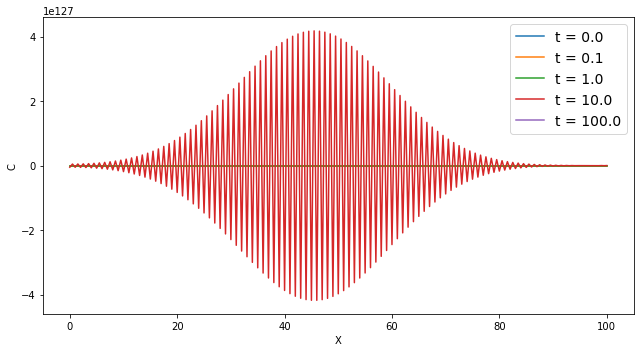

In [7]:
# Plot the solution at a few different times:
timesteps = [0, 10, 100, 1000, 10000]

fig = plt.figure(figsize = (9, 5))
for it in timesteps:
    plt.plot(X, C[it,:], label = f't = {it*dt}')
    
plt.xlabel('X')
plt.ylabel('C')
plt.legend(fontsize = 14)
plt.tight_layout()

Text(0, 0.5, 'Change in total mass')

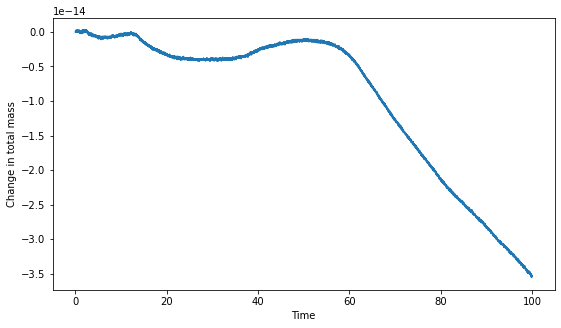

In [8]:
# Confirm that the no-flux boundary conditions
# worked as intended: No mass should have left
# the system.
fig = plt.figure(figsize = (9, 5))
# Integrate concentration to find mass for each time
mass = simps(C, x = X, axis = 1)
# Plot the change in mass from the initial value
times = np.linspace(0, Tmax, len(mass))
plt.plot(times, mass - mass[0])
plt.xlabel('Time')
plt.ylabel('Change in total mass')

### Example: Implicit scheme for the diffusion equation in 1D (Crank-Nicolson)

We will now repeat the same example as above, but with an implicit scheme in time, instead of the forward Euler scheme. We will use the Crank-Nicolson scheme (invented by John Crank and Phyllis Nicolson in the 1940s, in the time of analogue computers). For the equation

$$ \frac{\partial C}{\partial t} = F(C, x, t) $$

the time-discretisation in the Crank-Nicolson scheme is

$$ \frac{C^{i+1}_n - C^i_n}{\Delta t} = \frac{1}{2} \big( F(C^{i+1}_n, x_n, t_{i+1}) + F(C^{i}_n, x_n, t_{i}) \big). $$

In words, this scheme takes the average of the right-hand side of the PDE at times $t_i$ and $t_{i+1}$, and uses this to calculate the values at time $t_{i+1}$. Hence, this is an implicit scheme. Writing it out for our equation, we get

$$ C_n^{i+1} = C_n^i + K \frac{\Delta t}{2\Delta x^2} \big[ C_{n+1}^{i+1} - 2C_n^{i+1} + C_{n-1}^{i+1}  + C_{n+1}^i - 2C_n^i + C_{n-1}^i  \big]. $$

We treat the boundary points as before, eliminating the "ghost points" outside the boundaries.

Introducing the variable $\alpha = \frac{1}{2}K\frac{\Delta t}{\Delta x^2}$, we can write this as a system of linear equations:

$$ \left[ \begin{array}{ccccccccc}
1 + 2\alpha & -2\alpha &0&&\cdots&&0&0&0 \\
-\alpha & 1+2\alpha & -\alpha&0&&&&0&0 \\
 &&&&&&&& 0 \\
 &0& -\alpha & 1+2\alpha & -\alpha &0&&& \\
\vdots &&0& -\alpha & 1+2\alpha & -\alpha &0&&\vdots \\
 &&&0& -\alpha & 1+2\alpha & -\alpha &0& \\
0&&&&&&&& \\
0&0&&& &0& -\alpha & 1+2\alpha & -\alpha\\
0&0&0&&\cdots& &0& -2\alpha & 1+2\alpha \\
\end{array}\right]
\left[ \begin{array}{c} C_0^{i+1} \\ C_1^{i+1} \\ \vdots \\C_{n-1}^{i+1} \\ C_n^{i+1} \\C_{n+1}^{i+1} \\ \vdots \\ C_{N-1}^{i+1} \\C_N^{i+1} \end{array}\right] \\
= \left[ \begin{array}{ccccccccc}
1 - 2\alpha & 2\alpha &0&&\cdots&&0&0&0 \\
\alpha & 1-2\alpha & \alpha&0&&&&0&0 \\
 &&&&&&&& 0 \\
 &0& \alpha & 1-2\alpha & \alpha &0&&& \\
\vdots &&0& \alpha & 1-2\alpha & \alpha &0&&\vdots \\
 &&&0& \alpha & 1-2\alpha & \alpha &0& \\
0&&&&&&&& \\
0&0&&& &0& \alpha & 1-2\alpha & \alpha\\
0&0&0&&\cdots& &0& 2\alpha & 1-2\alpha \\
\end{array}\right]
\left[ \begin{array}{c} C_0^{i} \\ C_1^{i} \\ \vdots \\C_{n-1}^{i} \\ C_n^{i} \\C_{n+1}^{i} \\ \vdots \\ C_{N-1}^{i} \\C_N^{i} \end{array}\right] $$

In [9]:
from numba import jit

In [10]:
# Compiling this function with numba gains a speedup
# of about a factor 10 - 100 (depends on problem size)
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    # Make to extra arrays to avoid overwriting input
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        q = (b[i] - a[i-1]*c_[i-1])
        c_[i] = c[i]/q
        d_[i] = (d[i] - a[i-1]*d_[i-1])/q
    d_[N-1] = (d[N-1] - a[N-2]*d_[N-2])/(b[N-1] - a[N-2]*c_[N-2])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse array structure into separate diagonals,
    # and passes them to the numba-compiled solver defined above.
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

In [1]:
# Diffusion parameter
K = 15

# Specify domain
Xmin = 0
Xmax = 100
Nx = 10001
X, dx = np.linspace(Xmin, Xmax, Nx, retstep = True)

# Specify time and timestep
Tmax = 100
dt = 0.1
Nt = int(Tmax/dt)

# Check stability condition for this method
print(f'K*dt/dx**2 = {K*dt/dx**2}')

# Set up matrix for the right-hand side,
# using sparse diagonal matrix structure
alpha = K*dt/(2*dx**2)
sub_diag = alpha * np.ones(Nx-1)
main_diag = 2*alpha * np.ones(Nx)
super_diag = alpha * np.ones(Nx-1)
# Change two elements to account for boundary conditions
super_diag[0] = 2*alpha
sub_diag[-1] = 2*alpha
R = diags((sub_diag, 1-main_diag, super_diag), offsets = (-1, 0, 1))
# Set up matrix for the left-hand side, using symmetry
L = diags((-sub_diag, 1+main_diag, -super_diag), offsets = (-1, 0, 1))

# Initial value, a couple of Gaussians:
mu1, sigma1 = 46, 4
mu2, sigma2 = 53, 2
C0 = 0.5 *( (1/(sigma1*np.sqrt(2*np.pi))) * np.exp(-((X - mu1)/sigma1)**2 / 2) \
           + (1/(sigma2*np.sqrt(2*np.pi))) * np.exp(-((X - mu2)/sigma2)**2 / 2) )

# Array to hold solution at all times
C = np.zeros((Nt+1, Nx))
# Insert initial values
C[0,:] = C0

# Loop over time
tic = time()
for i in range(1, Nt+1):
    # First, calculate matrix-vector product on right-hand side
    x = R.dot(C[i-1,:])
    # Then, solve equation system on left-hand side
    C[i,:] = tdma(L, x)
toc = time()
print(f'Loop over timesteps took {toc - tic:.4f} seconds')

NameError: name 'np' is not defined

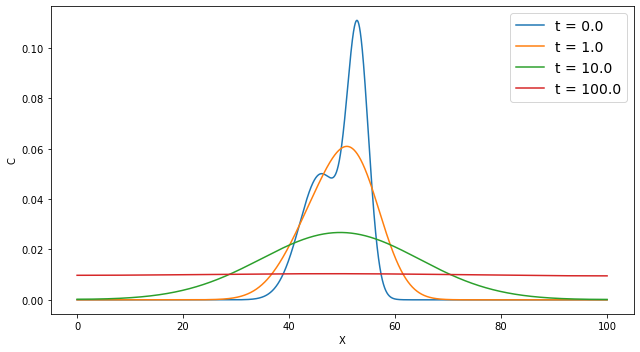

In [12]:
# Plot the solution at a few different times:
timesteps = [0, 10, 100, 1000]

fig = plt.figure(figsize = (9, 5))
for it in timesteps:
    plt.plot(X, C[it,:], label = f't = {it*dt}')
    
plt.xlabel('X')
plt.ylabel('C')
plt.legend(fontsize = 14)
plt.tight_layout()

Text(0, 0.5, 'Change in total mass')

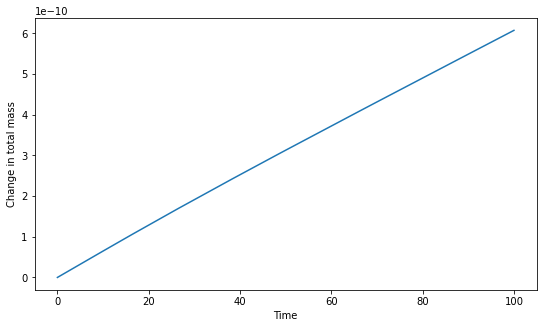

In [13]:
# Confirm that the no-flux boundary conditions
# worked as intended: No mass should have left
# the system.
fig = plt.figure(figsize = (9, 5))
# Integrate concentration to find mass for each time
mass = simps(C, x = X, axis = 1)
# Plot the change in mass from the initial value
times = np.linspace(0, Tmax, len(mass))
plt.plot(times, mass - mass[0])
plt.xlabel('Time')
plt.ylabel('Change in total mass')

## How can we test the accuracy and estimate the error of these methods?

In this case, we can compare to analytic solutions, but that is not always the case. When there is no known analytic solution, we have to use numerical means to estimate the error. A convergence test, or grid-refinement study (probably also called other things) consists of running the calculation several times with different numerical parameters, and checking the error relative to the most accurate numerical solution.

Below, we will see this for the Crank-Nicolson scheme. The Crank-Nicolson scheme is second order in space, and second order in time. This means that the error in the solution, at the end of the calculation, can be written:

$$  E(\Delta x, \Delta t) = \mathcal{O}(\Delta t^2) + \mathcal{O}(\Delta x^2) + \textrm{higher order terms}. $$

The error is defined as the difference between the numerical solution, and the true (but often unknown) solution. However, since we don't have access to the true solution, we can approximate it by a more accurate numerical solution.

Let's say we want to find the error at timestep $\Delta t$. Then we calculate the numerical solution with that timestep, and also with another, much shorter timestep, $\Delta t_{ref}$ (keeping the spatial discretisation constant). Then the error in the more accurate reference solution will be small, compared to the error in the result with the long timestep, and therefore we get a good approximation of the true error at timestep $\Delta t$, if we take the difference between that solution, and the reference solution.

In [14]:
# First, define a function to run the simulation, for convenience
def CrankNicolson(X, C0, Tmax, dt, K = 10):
    C = C0.copy()
    # Specify domain, Nx is inferred from X
    Nx = len(X)
    dx = X[1] - X[0]

    # Specify time and number of timesteps
    Tmax = 100
    Nt = int(Tmax/dt)

    # Set up matrix for the right-hand side,
    # using sparse diagonal matrix structure
    alpha = K*dt/(2*dx**2)
    sub_diag = alpha * np.ones(Nx-1)
    main_diag = 2*alpha * np.ones(Nx)
    super_diag = alpha * np.ones(Nx-1)
    # Change two elements to account for boundary conditions
    super_diag[0] = 2*alpha
    sub_diag[-1] = 2*alpha
    R = diags((sub_diag, 1-main_diag, super_diag), offsets = (-1, 0, 1))
    # Set up matrix for the left-hand side, using symmetry
    L = diags((-sub_diag, 1+main_diag, -super_diag), offsets = (-1, 0, 1))

    # Loop over time
    for i in range(1, Nt+1):
        # First, calculate matrix-vector product on right-hand side
        rhs = R.dot(C)
        # Then, solve equation system on left-hand side
        C = tdma(L, rhs)
    return C

### Convergence with respect to timestep

In [15]:
#### Common parameters ####

# Integration time
Tmax = 10
# Specify domain
Xmin = 0
Xmax = 100
Nx = 201
X, dx = np.linspace(Xmin, Xmax, Nx, retstep = True)
# Initial value, a couple of Gaussians:
mu1, sigma1 = 46, 4
mu2, sigma2 = 93, 2
C0 = 0.5 *( (1/(sigma1*np.sqrt(2*np.pi))) * np.exp(-((X - mu1)/sigma1)**2 / 2) \
           + (1/(sigma2*np.sqrt(2*np.pi))) * np.exp(-((X - mu2)/sigma2)**2 / 2) )

# List of timesteps to test (approximately log-spaced,
# but they all divide Tmax evenly)
timesteps = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10])

# Presumed accurate reference solution:
C_ref = CrankNicolson(X, C0, Tmax, dt = 0.001)
# First moment of reference solution
M1_ref = simps(C_ref*X, x = X)

# Check different measures of the error
# (first moment, and RMS error)
M1_error = np.zeros(len(timesteps))
RMS_error = np.zeros(len(timesteps))
# Store results, for later plotting
results = []

# Loop over timesteps
for i, dt in enumerate(timesteps):
    C = CrankNicolson(X, C0, Tmax, dt)
    results.append(C.copy())
    M1_error[i] = np.abs(M1_ref - simps(C*X, x = X))
    RMS_error[i] = np.sqrt(np.mean((C - C_ref)**2))

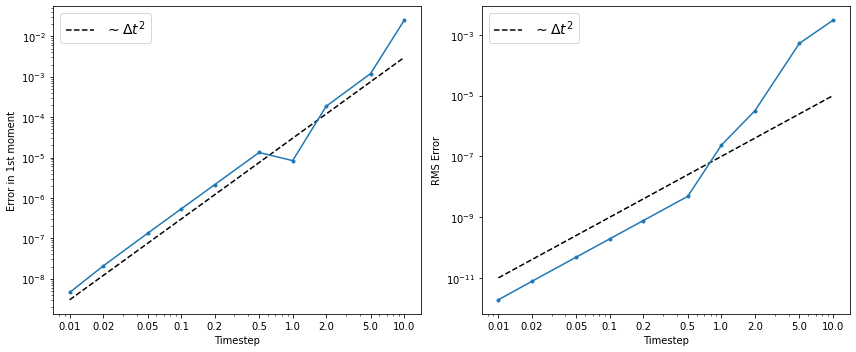

In [16]:
# Plot results
fig, ax = plt.subplots(ncols = 2, figsize = (12,5))

ax[0].plot(timesteps, 3e-5*timesteps**2, '--', c = 'k', label = '$\sim \Delta t^2$')
ax[0].plot(timesteps, M1_error, marker = '.')
ax[0].set_ylabel('Error in 1st moment')

ax[1].plot(timesteps, 1e-7*timesteps**2, '--', c = 'k', label = '$\sim \Delta t^2$')
ax[1].plot(timesteps, RMS_error, marker = '.')
ax[1].set_ylabel('RMS Error')


for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(fontsize = 14)
    a.set_xticks(timesteps)
    a.set_xticklabels(timesteps)
    a.set_xlabel('Timestep')
    
plt.tight_layout()

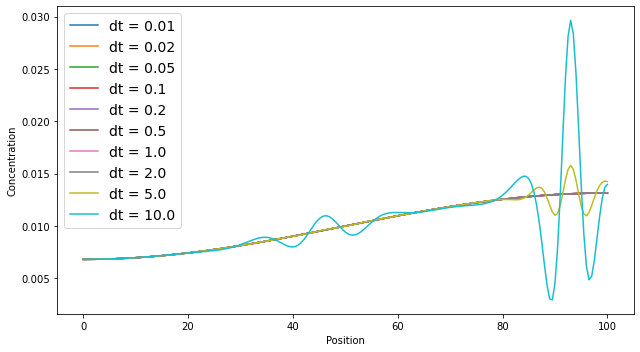

In [17]:
# plot solutions for different timesteps, to illustrate
# the concept of oscillating solutions, which happen
# with the Crank-Nicolson scheme when the timestep is too long
# (note that the method is still stable, as the oscillations do not grow exponentially)

fig = plt.figure(figsize = (9, 5))
for i, C in enumerate(results):
    plt.plot(X, C, label = f'dt = {timesteps[i]}')
    
plt.legend(fontsize = 14)
plt.ylabel('Concentration')
plt.xlabel('Position')
plt.tight_layout()

### Convergence with respect to grid spacing

In [18]:
#### Common parameters ####

# Integration time and timestep
Tmax = 10
dt = 0.1
# Specify domain
Xmin = 0
Xmax = 100
# Initial value, a couple of Gaussians
# (specified as a function here, to be
# evaluated for different resolutions later)
mu1, sigma1 = 46, 4
mu2, sigma2 = 93, 2
C0_func = lambda X: 0.5 *( (1/(sigma1*np.sqrt(2*np.pi))) * np.exp(-((X - mu1)/sigma1)**2 / 2) \
           + (1/(sigma2*np.sqrt(2*np.pi))) * np.exp(-((X - mu2)/sigma2)**2 / 2) )


# List of grid spacings to test, specified via number of cells
cellnumbers = np.array([11, 21, 51, 101, 201, 501, 1001])
gridspacings = (Xmax - Xmin) / (cellnumbers-1)

# Presumed accurate reference solution:
Nx_ref = 5001
X, dx = np.linspace(Xmin, Xmax, Nx_ref, retstep = True)
C0 = C0_func(X)
C_ref = CrankNicolson(X, C0, Tmax, dt = 0.001)
# First moment of reference solution
M1_ref = simps(C_ref*X, x = X)

# Check different measures of the error
# (first moment, and RMS error)
M1_error = np.zeros(len(gridspacings))
RMS_error = np.zeros(len(gridspacings))
# Store results, for later plotting
results = []

# Loop over gridspacings / cellnumbers
for i, Nx in enumerate(cellnumbers):
    X, dx = np.linspace(Xmin, Xmax, Nx, retstep = True)
    C0 = C0_func(X)
    C = CrankNicolson(X, C0, Tmax, dt)
    results.append(C.copy())
    M1_error[i] = np.abs(M1_ref - simps(C*X, x = X))
    # Do a little index-trickery to make sure we compare the same positions
    Nskip = int((Nx_ref-1)/(Nx-1))
    RMS_error[i] = np.sqrt(np.mean((C - C_ref[::Nskip])**2))

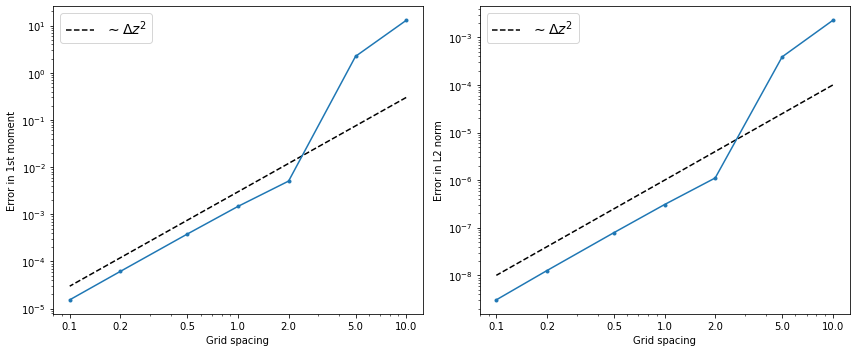

In [19]:
# Plot results
fig, ax = plt.subplots(ncols = 2, figsize = (12,5))

ax[0].plot(gridspacings, 3e-3*gridspacings**2, '--', c = 'k', label = '$\sim \Delta z^2$')
ax[0].plot(gridspacings, M1_error, marker = '.')
ax[0].set_ylabel('Error in 1st moment')

ax[1].plot(gridspacings, 1e-6*gridspacings**2, '--', c = 'k', label = '$\sim \Delta z^2$')
ax[1].plot(gridspacings, RMS_error, marker = '.')
ax[1].set_ylabel('Error in L2 norm')


for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(fontsize = 14)
    a.set_xticks(gridspacings)
    a.set_xticklabels(gridspacings)
    a.set_xlabel('Grid spacing')
    
plt.tight_layout()

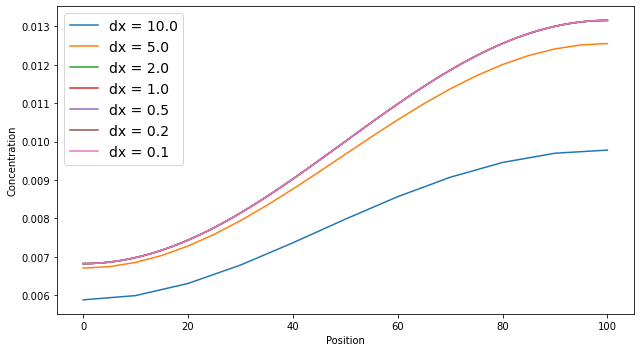

In [20]:
# plot solutions for different grid spacings

fig = plt.figure(figsize = (9, 5))
for i, C in enumerate(results):
    Nx = len(C)
    X = np.linspace(Xmin, Xmax, Nx)
    plt.plot(X, C, label = f'dx = {gridspacings[i]}')
    
plt.legend(fontsize = 14)
plt.ylabel('Concentration')
plt.xlabel('Position')
plt.tight_layout()

## 2D Advection-diffusion equation with implicit method

Next, we will look at the advection-diffusion equation in 2D. This equation reads

$$ \frac{\partial C}{\partial t} = \nabla \left( K \nabla C \right) - \nabla(vC),$$

but we will look at the simpler case where $K$ is a constant, such that we have

$$ \frac{\partial C}{\partial t} = K \nabla^2 C - \nabla(vC).$$

As before, we introduce discrete variables and shorthand notation:

$$ x_i = x_0 + i \Delta x, \;\; y_j = y_0 + j \Delta y, \;\; t_n = t_0 + n \Delta t, \;\; C_{i,j}^n = C(x_i, y_j, t_n), \;\;\; v^x_{i,j} = v_x(x_i, y_j), \;\;\; v^y_{i,j} = v_y(x_i, y_j),$$
with
$$ i = 0,1,\ldots,N_x,\;\;\;j = 0,1,\ldots,N_y.$$

Discretising the spatial derivatives with central finite difference (both for the first and second derivatives) we get

$$ \frac{\partial C_{i,j}}{\partial t} \approx K \Delta t \left[ \frac{C_{i+1,j}(t) - 2C_{i,j}(t) + C_{i-1,j}(t)}{\Delta x^2} + \frac{C_{i,j+1}(t) - 2C_{i,j}(t) + C_{i,j-1}(t)}{\Delta x^2} \right] \\ 
-  \Delta t  \left[ v^x_{i,j} \frac{C_{i+1,j}(t) - C_{i-1,j}(t)}{2\Delta x} + v^y_{i,j} \frac{C_{i,j+1}(t) - C_{i,j-1}(t)}{2\Delta y} + C_{i,j} \frac{v^x_{i+1,j}(t) - v^x_{i-1,j}(t)}{2\Delta x} + C_{i,j} \frac{v^x_{i,j+1}(t) - v^x_{i,j-1}(t)}{2\Delta y} \right]. $$

In this case, we implement periodic boundary conditions, where we let $C_{i,0} = C_{i,N_y}$, and $C_{0,j} = C_{N_x,j}$.

Using the Crank-Nicolson scheme to discretise in time, and flattening the 2D grid $C_{i,j}$ into a vector, we can rewrite this into a matrix equation similar to the ones we have seen before, but with five non-zero elements in each row, instead of just three. This is left as an exercise to the reader.

As velocity field, we will use an analytical expression that gives a divergence free 2D velocity field.

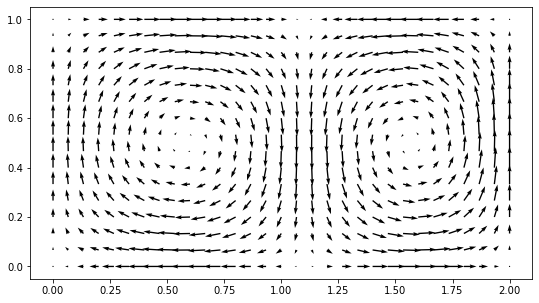

In [7]:
# Velocity field
def doublegyre(x, y, t, A=0.1, e=0.1, w=2*np.pi):
    a = e * np.sin(w*t)
    b = 1 - 2*e*np.sin(w*t)
    f = a*x**2 + b*x
    return np.array([
            -np.pi*A*np.sin(np.pi*f) * np.cos(np.pi*y),              # x component of velocity
             np.pi*A*np.cos(np.pi*f) * np.sin(np.pi*y) * (2*a*x + b) # y component of velocity
        ])

# Plot for illustration
x = np.linspace(0, 2, 31)
y = np.linspace(0, 1, 16)

Y, X = np.meshgrid(y, x)

vx, vy = doublegyre(X, Y, 0.25)

fig = plt.figure(figsize = (9,5))
plt.quiver(X, Y, vx, vy)

In [22]:
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spilu, LinearOperator, bicgstab

In [23]:
# Function that sets up the two matrices L and R in the matrix equation
def setup_matrices(Nx, Ny, dt, dx, dy, K, vx, vy):
    # Total number of cells
    N = Nx*Ny
    # Equation matrices
    # scipy.sparse documentation recommends constructing
    # sparse matrices as lil_matrix, and then converting to desired form
    L = lil_matrix((N, N))
    R = lil_matrix((N, N))
    # Coefficients
    alpha_x = K*dt/dx**2
    alpha_y = K*dt/dy**2
    beta_x  = dt/dx
    beta_y  = dt/dy
    # Naïve (and slow) setup with loops for easier debugging
    for i in range(Nx):
        for j in range(Ny):
            # Calculate derivatives (with prefactor included)
            dvxdx = beta_y*(vx[ j      ,(i+1)%Nx] - vx[ j      ,(i-1)%Nx]) / 4
            dvydy = beta_x*(vy[(j+1)%Ny, i      ] - vy[(j-1)%Ny, i      ]) / 4
            # Calculate index on main diagonal in L and R
            n = i + Nx*j
            # Main diagonal
            L[n, n] = 1 + alpha_x + alpha_y + dvxdx + dvydy
            R[n, n] = 1 - alpha_x - alpha_y - dvxdx - dvydy
            # Sub-diagonal, corresponding to one cell offset in x
            L[n, (n-1)%Nx + Nx*j] = -(1/2)*alpha_x - (vx[j,i]/4)*beta_x
            R[n, (n-1)%Nx + Nx*j] = +(1/2)*alpha_x + (vx[j,i]/4)*beta_x
            # Super-diagonal, corresponding to one cell offset in x
            L[n, (n+1)%Nx + Nx*j] = -(1/2)*alpha_x + (vx[j,i]/4)*beta_x
            R[n, (n+1)%Nx + Nx*j] = +(1/2)*alpha_x - (vx[j,i]/4)*beta_x
            # Subsub...sub-diagonal, corresponding to one cell offset in y
            L[n, (n-Nx)%N] = -(1/2)*alpha_y - (vy[j,i]/4)*beta_y
            R[n, (n-Nx)%N] = +(1/2)*alpha_y + (vy[j,i]/4)*beta_y
            # Supersuper...super-diagonal, corresponding to one cell offset in y
            L[n, (n+Nx)%N] = -(1/2)*alpha_y + (vy[j,i]/4)*beta_y
            R[n, (n+Nx)%N] = +(1/2)*alpha_y - (vy[j,i]/4)*beta_y
    # Converting to diagonal sparse matrices
    return L.todia(), R.todia()

In [25]:
# System parameters
Lx = 2
Ly = 1
Nx = 320
Ny = 160
# Timestep
dt = 0.01
Tmax = 20
Nt = int(Tmax / dt) + 1

# Cell faces
xf = np.linspace(0, Lx, Nx+1)
yf = np.linspace(0, Ly, Ny+1)
# Grid spacing
dx = xf[1] - xf[0]
dy = yf[1] - yf[0]
# Cell centers
xc = xf[:-1] + dx/2
yc = yf[:-1] + dy/2
# Grid points
gridx, gridy = np.meshgrid(xc, yc)

# Diffusivity (constant in space and time)
K = 0.002
# Velocity (constant in time)
vx, vy = doublegyre(gridx, gridy, 0)

# Initial concentration (gaussian)
x0, y0 = 1.04, 0.5
sx, sy = 0.05, 0.05
# Create concentration field
C0 = np.exp(-(gridx - x0)**2/(2*sx**2) - (gridy-y0)**2/(2*sy**2))
C = np.zeros((Nt, Ny, Nx))
C[0,:] = C0

L, R = setup_matrices(Nx, Ny, dt, dx, dy, K, vx, vy)
# Find preconditioner for matrix L (constant in time, so we only do this once)
# Note: I actually found this to be slower with preconditioner in this case
#ILU = spilu(csc_matrix(L))
#Minv = LinearOperator(L.shape, lambda x: ILU.solve(x))


# Stability criteria
print(f'Timestep is: ', dt)
print(f'Timestep should be smaller than about: {min(dx, dy)**2 / K:.5f} according to dubious wikipedia entry, check this')
print(f'Cell Péclet number in x-direction: {np.amax(dx*vx/K):.5f}')
print(f'Cell Péclet number in y-direction: {np.amax(dy*vy/K):.5f}')

for i in trange(1, Nt):
    rhs = R.dot(C[i-1,:].flatten())
    # Note: I actually found this to be slower with ILU preconditioner in this case
    # Uncomment the part with M = Minv to test with preconditioner
    tmp, status = bicgstab(L, rhs, x0 = C[i-1,:].flatten(), tol = 1e-9)#, M = Minv)
    if status != 0:
        print('Bicgstab failed, with error: ', status)
    C[i, :] = tmp.reshape(Ny, Nx)

Timestep is:  0.01
Timestep should be smaller than about: 0.01953 according to dubious wikipedia entry, check this
Cell Péclet number in x-direction: 0.98165
Cell Péclet number in y-direction: 0.98165


In [26]:
# Note that the matrices L and R are very large, so this would
# not at all be practical without the use of sparse arrays
print(f'L.shape = {L.shape}')

L.shape = (51200, 51200)


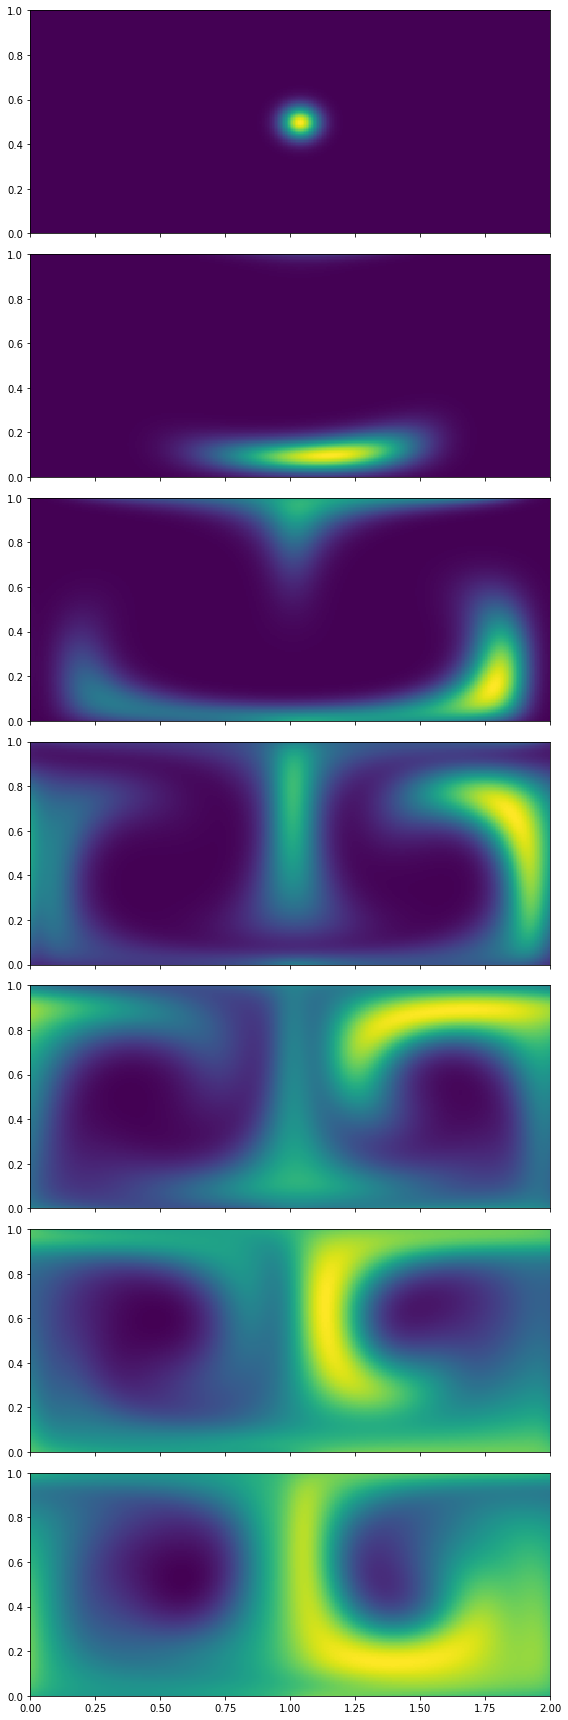

In [27]:
Nplots = 7
Nskip = 200

fig, ax = plt.subplots(nrows=Nplots, figsize = (8,24), sharex = True, sharey = True)

for i in range(Nplots):
    ax[i].pcolormesh(xf, yf, C[i*Nskip,:,:])
    
plt.tight_layout()

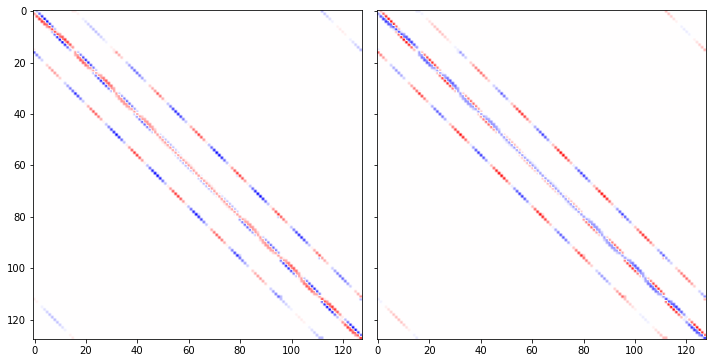

In [28]:
# Plot matrices for illustration, using a smaller system
# System parameters
Lx = 2
Ly = 1
Nx = 16
Ny = 8
# Timestep
dt = 0.01

# Cell faces
xf = np.linspace(0, Lx, Nx+1)
yf = np.linspace(0, Ly, Ny+1)
# Grid spacing
dx = xf[1] - xf[0]
dy = yf[1] - yf[0]
# Cell centers
xc = xf[:-1] + dx/2
yc = yf[:-1] + dy/2
# Grid points
gridx, gridy = np.meshgrid(xc, yc)

# Diffusivity (constant in space and time)
K = 0.002
# Velocity (constant in time)
vx, vy = doublegyre(gridx, gridy, 0)

L, R = setup_matrices(Nx, Ny, dt, dx, dy, K, vx, vy)

fig, ax = plt.subplots(ncols = 2, figsize = (10,5), sharex = True, sharey = True)
L_dense_scaled = L.todense() - np.identity(Nx*Ny)
R_dense_scaled = R.todense() - np.identity(Nx*Ny)
vmax = np.amax(np.abs(L_dense_scaled))

ax[0].imshow(L_dense_scaled, cmap = plt.cm.bwr, vmin = -vmax, vmax = vmax)
ax[1].imshow(R_dense_scaled, cmap = plt.cm.bwr, vmin = -vmax, vmax = vmax)
plt.tight_layout()

# What about non-linear PDEs?

The regular advection-diffusion equation in 1D, with constant coefficients $K$ and $v$ is:

$$ \frac{\partial C}{\partial t} = K \frac{\partial^2 C}{\partial z^2} - v \frac{\partial C}{\partial z}. $$

The generalised Burgers' equation in 1D reads:

$$ \frac{\partial C}{\partial t} = K \frac{\partial^2 C}{\partial z^2} - v(C) \frac{\partial C}{\partial z}. $$

So the equation is very similar, except that the advection speed depends on the concentration. This gives a non-linear equation, and this causes problems for the Crank-Nicolson method, which is based on solving a system of *linear* equations.

We will see how this can be solved with an iterative approach.

Note that the Crank-Nicolson scheme with central finite differences in space is not particularly well suited for this type of equation. Refer to Chapter 11 in *High Order Difference Methods for Time Dependent PDE* by Bertil Gustafsson for further details: https://link.springer.com/book/10.1007%2F978-3-540-74993-6

See also: https://folk.ntnu.no/leifh/teaching/tkt4140/._main075.html

In [29]:
def setup_matrices_burgers(C, v, K = 0.001):
    # Set up matrix for the right-hand side,
    # using sparse diagonal matrix structure
    alpha = K*dt/(2*dx**2)
    beta = dt/(4*dx)
    sub_diag = alpha * np.ones(Nx-1) + beta*v(C[1:])
    main_diag = 2*alpha * np.ones(Nx) 
    super_diag = alpha * np.ones(Nx-1) - beta*v(C[:-1])
    # Change two elements to account for boundary conditions
    # Note: This does not correctly handle the boundary condition
    # for advection, but it works for the example below.
    # Should fix this later.
    super_diag[0] = 2*alpha
    sub_diag[-1] = 2*alpha
    R = diags((sub_diag, 1-main_diag, super_diag), offsets = (-1, 0, 1))
    # Set up matrix for the left-hand side, using symmetry
    L = diags((-sub_diag, 1+main_diag, -super_diag), offsets = (-1, 0, 1))
    return L, R

In [30]:
# Specify domain
Xmin = 0
Xmax = 100
Nx = 1001
X, dx = np.linspace(Xmin, Xmax, Nx, retstep = True)

# Specify time and timestep
Tmax = 100
dt = 0.01
Nt = int(Tmax/dt)

# Velocity function
v = lambda C : 0.2 + 3*C

# Initial value, Gaussian:
mu1, sigma1 = 30, 6
C0 = (1/(sigma1*np.sqrt(2*np.pi))) * np.exp(-((X - mu1)/sigma1)**2 / 2)

# Array to hold solution at all times
C = np.zeros((Nt+1, Nx))
# Insert initial values
C[0,:] = C0

# Tolerance in iterative scheme
tol = 1e-6
# Loop over time
tic = time()
for i in trange(1, Nt+1):
    # Copy current values
    C_now = C[i-1,:]
    # First, set up matrices
    L, R = setup_matrices_burgers(C_now, v)
    # First, calculate matrix-vector product on right-hand side
    rhs = R.dot(C_now)
    norm = 2*tol
    while norm > tol:
        # Solve equation system on left-hand side
        C_next = tdma(L, rhs)
        # Calculate norm of change
        norm = np.linalg.norm(C_next - C_now)
        # Update value
        C_now = C_next
        # Calculate new matrix on the left-hand side only
        L, _ = setup_matrices_burgers(C_now, v)
    # Store reslut of iterations
    C[i,:] = C_now
    
toc = time()
print(f'Loop over timesteps took {toc - tic:.4f} seconds')


Loop over timesteps took 7.7572 seconds


10000


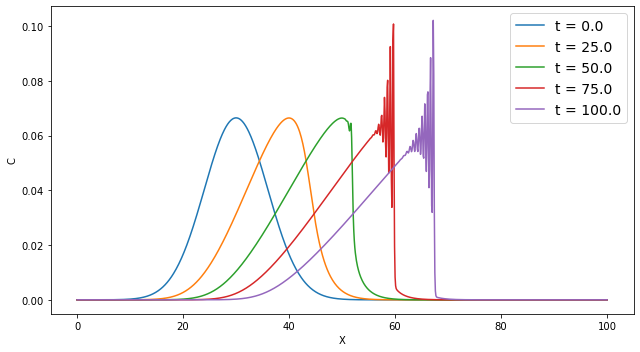

In [31]:
# Plot solution for different timesteps
timesteps = [0, 2500, 5000, 7500, 10000]

print(Nt)
fig = plt.figure(figsize = (9, 5))
for it in timesteps:
    plt.plot(X, C[it,:], label = f't = {it*dt}')
    
plt.legend(fontsize = 14)
plt.xlabel('X')
plt.ylabel('C')
plt.tight_layout()

Text(0, 0.5, 'Change in total mass')

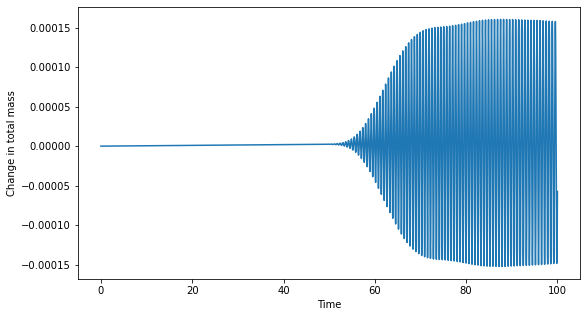

In [32]:
# Confirm that the no-flux boundary conditions
# worked as intended: No mass should have left
# the system.
fig = plt.figure(figsize = (9, 5))
# Integrate concentration to find mass for each time
mass = simps(C, x = X, axis = 1)
# Plot the change in mass from the initial value
times = np.linspace(0, Tmax, len(mass))
plt.plot(times, mass - mass[0])
plt.xlabel('Time')
plt.ylabel('Change in total mass')

### Upwind scheme for the advection part of the Burgers' equation

The generalised Burgers' equation in 1D reads:

$$ \frac{\partial C}{\partial t} = K \frac{\partial^2 C}{\partial z^2} - v(C) \frac{\partial C}{\partial z}. $$

Discretising this with a central finite difference for the 2nd derivative (diffusion), a one-sided (upwind) finite difference for the 1st derivative (advection), and forward Euler in time, we get:

$$ C_n^{i+1} = C_n^i + K \frac{\Delta t}{\Delta x^2} \big[ C_{n+1}(t) - 2C_n(t) + C_{n-1}(t) \big] - v(C_n^i)\frac{\Delta t}{\Delta x} \big[ C_n^i -C_{n-1}^i \big]. $$

In [33]:
# Specify domain
Xmin = 0
Xmax = 100
Nx = 501
X, dx = np.linspace(Xmin, Xmax, Nx, retstep = True)

# Specify time and timestep
Tmax = 100
dt = 0.01
Nt = int(Tmax/dt)

# Velocity function
v = lambda C : 0.2 + 3*C

# Initial value, Gaussian:
mu1, sigma1 = 30, 6
C0 = (1/(sigma1*np.sqrt(2*np.pi))) * np.exp(-((X - mu1)/sigma1)**2 / 2)

# Array to hold solution at all times
C = np.zeros((Nt+1, Nx))
# Insert initial values
C[0,:] = C0

# Coefficients
K = 1e-3
alpha = K*dt/dx**2
beta = dt/dx

# Loop over time
tic = time()
for i in trange(1, Nt+1):
    C[i,1:-1] = C[i-1,1:-1] + alpha*(C[i-1,2:] - 2*C[i-1,1:-1] + C[i-1,:-2]) - v(C[i-1,1:-1])*beta*(C[i-1,1:-1] - C[i-1,:-2])
    
toc = time()
print(f'Loop over timesteps took {toc - tic:.4f} seconds')


Loop over timesteps took 0.2000 seconds


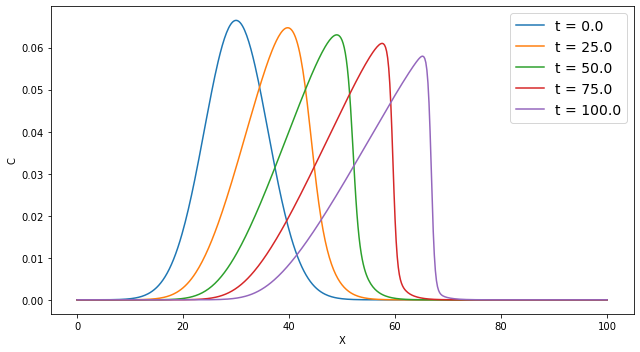

In [34]:
# Plot solution for different timesteps
timesteps = timesteps = [0, 2500, 5000, 7500, 10000]


fig = plt.figure(figsize = (9, 5))
for it in timesteps:
    plt.plot(X, C[it,:], label = f't = {it*dt}')
    
plt.legend(fontsize = 14)
plt.xlabel('X')
plt.ylabel('C')
plt.tight_layout()

Text(0, 0.5, 'Change in total mass')

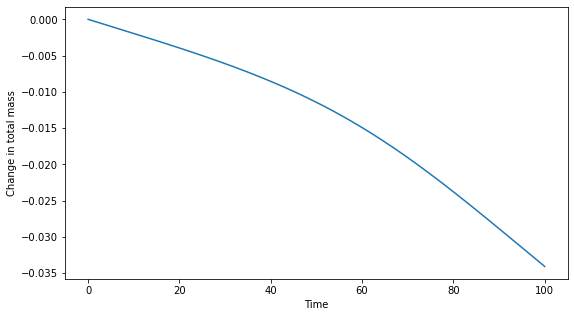

In [35]:
# Confirm that the no-flux boundary conditions
# worked as intended: No mass should have left
# the system.
fig = plt.figure(figsize = (9, 5))
# Integrate concentration to find mass for each time
mass = simps(C, x = X, axis = 1)
# Plot the change in mass from the initial value
times = np.linspace(0, Tmax, len(mass))
plt.plot(times, mass - mass[0])
plt.xlabel('Time')
plt.ylabel('Change in total mass')

## 2D Wave equation

Explicit scheme for the 2D wave equation. See details in slides.

In [36]:
# We apply these for both x and y
Xmin = 0
Xmax = 1
Nx   = 200
# Set up x using Xmin, Xmax, Nx, and calculate dx
# Alternative would be to calculate dx, and use that
# to set up x. Just make sure that they are consistent.
x, dx    = np.linspace(Xmin, Xmax, Nx, retstep = True)

# How long to integrate in time
Tmax = 1
dt   = 0.002
Nt   = int(Tmax/dt)

# Prefactor
C = dt**2 / dx**2
print('C = ', C)

# Dimension Nt+2 to hold previous, current and next timestep
U = np.zeros((Nt+2, Nx + 2, Nx + 2)) # Adding ghost cells

# Setup, initial values and current value

# Initial condition
X, Y   = np.meshgrid(x, x)
U[0,1:Nx+1,1:Nx+1] = np.sin(np.pi*X)*np.sin(2*np.pi*Y)

# Set up current value, based on initial condition,
# using special stencil the first time only.
# (for loop formulation)
for i in range(1, Nx+1):
    for j in range(1, Nx+1):
        U[1,i,j] = U[0,i,j] + \
            0.5*C*(U[0,i+1,j] + U[0,i+1,j] + U[0,i+1,j] + U[0,i+1,j] - 4*U[0,i+1,j])

C =  0.158404


In [37]:
# Now we are ready to proceed with the regular time loop

# This implementation uses array operations with
# offset indexing, to do the same thing as the double
# for loop above in one expression. This is much more efficient.
t = 0
tic = time()
for i in range(2, Nt+1):
    # Calculate next step, then copy:
    # current -> previous
    # next -> current
    U[i, 1:Nx+1, 1:Nx+1] = \
        2*U[i-1, 1:Nx+1, 1:Nx+1] - U[i-2, 1:Nx+1, 1:Nx+1] + \
        C*( 
                U[i-1,2:,1:Nx+1] + U[i-1,:Nx,1:Nx+1] 
            +   U[i-1,1:Nx+1,2:] + U[i-1,1:Nx+1,:Nx]
            - 4*U[i-1,1:Nx+1,1:Nx+1]
        )
toc = time()
print(f'The calculation took {toc-tic:.4f} seconds')

The calculation took 0.2080 seconds


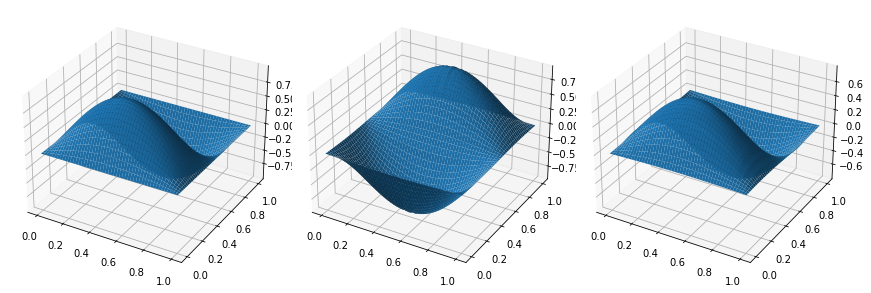

In [38]:
# Plot a few different solutions
# Plotting as 3D surface plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (12, 5))
ax0  = fig.add_subplot(131, projection = '3d')
ax1  = fig.add_subplot(132, projection = '3d')
ax2  = fig.add_subplot(133, projection = '3d')

ax0.plot_surface(X, Y, U[1, 1:Nx+1, 1:Nx+1])
ax1.plot_surface(X, Y, U[int(Nt/2), 1:Nx+1, 1:Nx+1])
ax2.plot_surface(X, Y, U[Nt, 1:Nx+1, 1:Nx+1])

plt.tight_layout()